# Checking GPU available for trining

In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Importing libraries

In [2]:
#importing the libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import json
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, GlobalMaxPooling1D, Flatten
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import joblib
import gradio as gr

# Data importing

In [3]:
res = json.load(open('covid_responses.json'))
res

{'greeting': ['Hi. How can I assist you today with your COVID-19 concerns?',
  'Hi! I am here to help you navigate COVID-19. What can I do for you?',
  'Greetings! As a COVID-19 checker, I am here to provide you with the information and resources you need to stay safe and healthy.',
  'Good to see you! Let me know how I can help you with the COVID-19.',
  'Hi, how can I help you today? I am here to support you with all of your COVID-19 related needs.',
  'Hello! Are you tested positive or shown any symptoms of COVID?',
  'Hello! Are you currently having COVID or did you recover from COVID?',
  'Hello! Could you specify the condition you are facing?'],
 'goodbye': ['Okay, Bye',
  'Have a nice day',
  'Goodbye',
  'see you later',
  'nice conversation. bye',
  'okay. Have a nice day',
  'Take care',
  'Yeah Sure, Will talk to you later',
  'Okay , Take care'],
 'covid_intro': ['Coronaviruses are a large family of viruses which may cause illness in animals or humans. COVID-19 is the infec

In [4]:
file = pd.read_csv('data.csv')
data = file[['inputs', 'tags']]
data = data.sample(frac=1)
data.head()

,inputs,tags
339,Do you know the consistent symptoms of COVID-19,symptoms
690,Should I use hydrochloroquine?,treatments
537,what corona virus causes low white blood cell ...,symptoms
116,is coronavirus a flu virus,covid_intro
154,Please explain corona virus,covid_intro


# cleaning data

In [5]:
import string
data['inputs'] = data['inputs'].apply(lambda wrd:[ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
data['inputs'] = data['inputs'].apply(lambda wrd: ''.join(wrd))
data

,inputs,tags
339,do you know the consistent symptoms of covid19,symptoms
690,should i use hydrochloroquine,treatments
537,what corona virus causes low white blood cell ...,symptoms
116,is coronavirus a flu virus,covid_intro
154,please explain corona virus,covid_intro
...,...,...
948,what kind of face mask should i use,prevention
45,explain coronavirus,covid_intro
466,is fever a symptom of the virus,symptoms
165,share with me all information about covid19,covid_intro


In [6]:
#tokenize the data
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(data['inputs'])
train = tokenizer.texts_to_sequences(data['inputs'])
#apply padding
from tensorflow.keras.preprocessing.sequence import pad_sequences
x_train = pad_sequences(train)

#encoding the outputs
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(data['tags'])
input_shape = x_train.shape[1]
print(input_shape)

18


# define vocabulary

In [7]:
vocabulary = len(tokenizer.word_index)
print("number of unique words : ",vocabulary)
output_length = le.classes_.shape[0]
print("output length: ",output_length)

number of unique words :  788
output length:  10


In [17]:
vocabulary

788

# creating the LSTM model

In [8]:
i = Input(shape=(input_shape,))
x = Embedding(vocabulary+1,10)(i)
x = LSTM(10,return_sequences=True)(x)
x = Flatten()(x)
x = Dense(output_length,activation="softmax")(x)
model  = Model(i,x)

# compiling the model

In [9]:
model.compile(loss="sparse_categorical_crossentropy",optimizer='adam',metrics=['accuracy'])

# training the model

In [10]:
train = model.fit(x_train,y_train,epochs=200)

Epoch 1/200
33/33 [==============================] - 5s 5ms/step - loss: 2.1844 - accuracy: 0.3125
Epoch 2/200
33/33 [==============================] - 0s 4ms/step - loss: 1.8070 - accuracy: 0.2888
Epoch 3/200
33/33 [==============================] - 0s 4ms/step - loss: 1.7459 - accuracy: 0.2888
Epoch 4/200
33/33 [==============================] - 0s 4ms/step - loss: 1.7040 - accuracy: 0.3134
Epoch 5/200
33/33 [==============================] - 0s 5ms/step - loss: 1.6119 - accuracy: 0.3996
Epoch 6/200
33/33 [==============================] - 0s 5ms/step - loss: 1.4619 - accuracy: 0.4621
Epoch 7/200
33/33 [==============================] - 0s 4ms/step - loss: 1.3269 - accuracy: 0.4754
Epoch 8/200
33/33 [==============================] - 0s 4ms/step - loss: 1.2233 - accuracy: 0.5341
Epoch 9/200
33/33 [==============================] - 0s 4ms/step - loss: 1.1374 - accuracy: 0.6165
Epoch 10/200
33/33 [==============================] - 0s 4ms/step - loss: 1.0476 - accuracy: 0.6723
Epoch 11/

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 18)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 18, 10)            7890      
_________________________________________________________________
lstm (LSTM)                  (None, 18, 10)            840       
_________________________________________________________________
flatten (Flatten)            (None, 180)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                1810      
Total params: 10,540
Trainable params: 10,540
Non-trainable params: 0
_________________________________________________________________


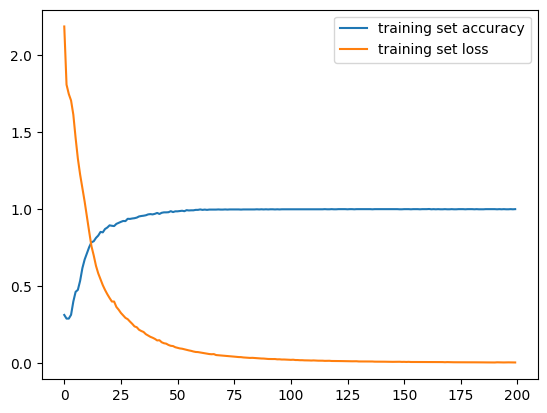

In [12]:
#plotting model accuracy
plt.plot(train.history['accuracy'],label='training set accuracy')
plt.plot(train.history['loss'],label='training set loss')
plt.legend()
plt.savefig('model_accuracy.png', dpi=300, bbox_inches='tight')

# saving model as saved_model

In [ ]:
# saving model to use with hugging face app
model.save('saved_model/my_model')

# checking responses of COVID chatbot

### in code chatbot

In [14]:
#chatting
import random


while True:
  texts_p = []
  prediction_input = input('You : ')

  #removing punctuation and converting to lowercase
  prediction_input = [letters.lower() for letters in prediction_input if letters not in string.punctuation]
  prediction_input = ''.join(prediction_input)
  texts_p.append(prediction_input)

  #tokenizing and padding
  prediction_input = tokenizer.texts_to_sequences(texts_p)
  prediction_input = np.array(prediction_input).reshape(-1)
  prediction_input = pad_sequences([prediction_input],input_shape)

  #getting output from model
  output = model.predict(prediction_input)
  output = output.argmax()

  #finding the right tag and predicting
  response_tag = le.inverse_transform([output])[0]
  print("Chatbot : ",random.choice(res[response_tag]))
  if response_tag == "goodbye":
    break

Chatbot :  Hello! Could you specify the condition you are facing?
Chatbot :  The most common symptoms of long COVID are extreme tiredness (fatigue), feeling short of breath, loss of smell, muscle aches. However, there are lots of symptoms you can have after a COVID-19 infection, including problems with your memory and concentration (brain fog), chest pain or tightness, difficulty sleeping (insomnia), heart palpitations, dizziness, pins and needles, joint pain, depression and anxiety, tinnitus, earaches, feeling sick, diarrhoea, stomach aches, loss of appetite, a high temperature, cough, headaches, sore throat, changes to sense of smell or taste and rashes.
Chatbot :  Coronaviruses are a large family of viruses which may cause illness in animals or humans. COVID-19 is the infectious disease caused by the most recently discovered coronavirus. COVID-19 were unknown before the outbreak began in Wuhan, China, in December 2019. The disease can spread from person to person through small dropl

KeyboardInterrupt: Interrupted by user

# testing with GUI

In [ ]:
def model_output(prediction_input):
  #removing punctuation and converting to lowercase
  prediction_input = [letters.lower() for letters in prediction_input if letters not in string.punctuation]
  prediction_input = ''.join(prediction_input)
  texts_p = []
  texts_p.append(prediction_input)

  #tokenizing and padding
  prediction_input = tokenizer.texts_to_sequences(texts_p)
  prediction_input = np.array(prediction_input).reshape(-1)
  prediction_input = pad_sequences([prediction_input],18)

  #getting output from model
  output = model.predict(prediction_input)
  output = output.argmax()

  #finding the right tag and predicting
  response_tag = le.inverse_transform([output])[0]
  final_response = str(random.choice(res[response_tag]))

  return final_response

dialog_app = gr.Interface(model_output, 
                        gr.Textbox(placeholder="Enter your question"), 
                        "text",
                        examples=[["What is COVID-19?"],[ "What are the symptoms?"], ["What are the precautions?"], ["What is the treatment?"]],
                        title="COVID-19 Chatbot",
                        description="Ask your questions about COVID-19",
)
dialog_app.launch()

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.
